In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\1442840785.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [13]:
def interpolator(dataset, time_increment):
    # Ensure dataset is a NumPy array and storing current and cycle columns
    dataset = np.array(dataset)
    current_value = dataset[0, 7]
    cycle_number_value = dataset[0, 8]

    # Calculate the minimum and maximum time values in the array
    min_time = dataset[:, 6].min()  
    max_time = dataset[:, 6].max()

    # Create a new array with the desired time increments
    new_time_values = np.arange(min_time, max_time, time_increment)

    # Forming an array for interpolated values
    interpolated_values = np.zeros((len(new_time_values), 6))

    # Interpolate columns
    for col_index in range(6):  # Adjust the range if the number of columns to interpolate differs
        interpolated_values[:, col_index] = np.interp(new_time_values, dataset[:, 6], dataset[:, col_index])

    # Combine interpolated values with constant values and new time values
    interpolated_data = np.column_stack((interpolated_values, new_time_values, np.full(len(new_time_values), current_value),
                                         np.full(len(new_time_values), cycle_number_value)))

    # Convert the result to a pandas DataFrame
    column_names = ['S8_cur', 'S4_cur','S2_cur','S1_cur','V_cur', 'Sp_cur', 't_cur','I', 'cycle number']  # Adjust column names as needed
    interpolated_df = pd.DataFrame(interpolated_data, columns=column_names)

    return interpolated_df

In [49]:
# Defined in the code
EH0 = 2.35
EL0 = 2.195
iH0 = 10
iL0 = 5
R = 8.3145
T = 298
F = 96490
fh = 0.7296
fl = 0.06654
ar = 0.96

def high_Nernst(EH0,R,T,F,fh,S8,S4):
  EH = EH0 + (((R*T)/(4*F))*np.log(fh*(S8/(S4**2))))
  return EH

def low_Nernst(EL0,R,T,F,fl,S4,S2,S):
  EL = EL0 + (((R*T)/(4*F))*np.log(fl*(S4/((S**2)*S2))))
  return EL

def high_BV(iH0,ar,F,R,T,V,EH):
  iH = 2*iH0*ar*np.sinh((4*F*(V-EH))/(2*R*T))
  return iH

def low_BV(iL0,ar,F,R,T,V,EL):
  iL = 2*iL0*ar*np.sinh((4*F*(V-EL))/(2*R*T))
  return iL

In [23]:
# Bisection method function
def f(V, EH, EL, I):
    # Defined in the code
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    return 2 * iH0 * ar * np.sinh((2 * F / (R * T)) * (V - EH)) + 2 * iL0 * ar * np.sinh((2 * F / (R * T)) * (V - EL)) + I

# Bisection method adjusted to accept EH, EL, and I
def bisection_method(V_a, V_b, EH, EL, I, tol=1e-9, max_iter=10000):
    if f(V_a, EH, EL, I) * f(V_b, EH, EL, I) >= 0:
        print("Bisection method fails.")
        return None

    V_m = V_a
    for _ in range(max_iter):
        V_m = (V_a + V_b) / 2
        if f(V_m, EH, EL, I) == 0 or np.abs(f(V_m, EH, EL, I)) < tol:   # (V_b - V_a)/2
            return V_m

        if f(V_m, EH, EL, I) * f(V_a, EH, EL, I) < 0:
            V_b = V_m
        else:
            V_a = V_m

    return V_m  # Return the approximation of the root

In [62]:
def scaler_func(X,y,current):
    
    # Scaling dataset for all the cycles combined (specific current)
    scale_columns_cur_X = ['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur', 'V_cur', 'Sp_cur','EH','EL','iH','iL']
    scale_columns_cur_y = ['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur', 'Sp_cur', 'V_cur']

    means = X[scale_columns_cur_X].mean()
    stds = X[scale_columns_cur_X].std()

    # Create a new DataFrame to store these values
    scales = pd.DataFrame([means, stds], index=['mean', 'std'])

    for i in scale_columns_cur_X:
        X[i] = (X[i] - scales.loc['mean', i]) / scales.loc['std', i]


    for j in scale_columns_cur_y:
        y[j] = (y[j] - scales.loc['mean', j])/scales.loc['std', j]

    scales['I'] = current

    return scales,X,y

In [60]:
def Data_formatter_cycles(current, data):

    X_cycles = pd.DataFrame(columns=['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur', 'V_cur', 'Sp_cur', 'I', 'EH', 'EL', 'iH', 'iL'])
    y_cycles = pd.DataFrame(columns=['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur', 'Sp_cur', 'V_cur'])

    # Extract unique cycle numbers to know how many times data formatting is required for particular cycle number
    unique_cycles = data['cycle'].unique()
    cycles = len(unique_cycles)

    for i in range(cycles):

        # Define the input dataset for the particular cycle
        X_array = data[data['I'] == current]
        X_array = X_array[X_array['cycle'] == i]
        X_array = X_array.iloc[1:,1:] # Removing first row as it has erraneous values


        # Linearly interpolating timescale for even data
        time_increment = 0.05
        X_array_interpolated = interpolator(X_array, time_increment)

        # Apply the functions to the desired columns
        X_array_interpolated['EH'] = X_array_interpolated.apply(lambda row: high_Nernst(EH0, R, T, F, fh, row[0], row[1]), axis=1)
        X_array_interpolated['EL'] = X_array_interpolated.apply(lambda row: low_Nernst(EL0, R, T, F, fl, row[1], row[2], row[3]), axis=1)

        X_array_interpolated['V_cur'] = X_array_interpolated.apply(lambda row: bisection_method(2.5, 2.1, row[9], row[10], current), axis=1)

        X_array_interpolated['iH'] = X_array_interpolated.apply(lambda row: high_BV(iH0, ar, F, R, T, row['V_cur'], row['EH']), axis=1)
        X_array_interpolated['iL'] = X_array_interpolated.apply(lambda row: low_BV(iL0, ar, F, R, T, row['V_cur'], row['EL']), axis=1)

        # Defining input array for NN
        filter_columns_cur = ['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur','V_cur', 'Sp_cur','I','EH','EL', 'iH', 'iL']
        X_array_interpolated = X_array_interpolated[filter_columns_cur]

        # Defining output array
        filter_columns_nxt = ['S8_cur', 'S4_cur', 'S2_cur', 'S1_cur','Sp_cur', 'V_cur']
        y_interpolated = X_array_interpolated[filter_columns_nxt]

        # Setting current input and next output
        y_interpolated = y_interpolated.iloc[1:,:]
        X_array_interpolated = X_array_interpolated.iloc[:-1,:]
        
        # Removing first value as it is erraneous
        y_interpolated = y_interpolated.iloc[1:,:]
        X_array_interpolated = X_array_interpolated.iloc[1:,:]

        # Append interpolated data to X
        X_cycles = pd.concat([X_cycles, X_array_interpolated[X_cycles.columns]], ignore_index=True)

        # Append subset of interpolated data to y
        y_cycles = pd.concat([y_cycles, y_interpolated[y_cycles.columns]], ignore_index=True)

    return X_cycles, y_cycles

In [61]:
data = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode//Data/Dataset.xlsx')
current = 1.6

X_cycles, y_cycles = Data_formatter_cycles(current, data)

# Join the DataFrames side by side
combined_df_unscaled = pd.concat([X_cycles, y_cycles], axis=1)

# Save the combined DataFrame as an Excel file for unscaled data
combined_df_unscaled.to_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode//Data/Dataset_unscaled_denoised.xlsx', index=False)

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\103487572.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_array_interpolated['EH'] = X_array_interpolated.apply(lambda row: high_Nernst(EH0, R, T, F, fh, row[0], row[1]), axis=1)
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\103487572.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_array_interpolated['EL'] = X_array_interpolated.apply(lambda row: low_Nernst(EL0, R, T, F, fl, row[1], row[2], row[3]), axis=1)
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\103487572.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.

In [63]:
scales,X,y = scaler_func(X_cycles,y_cycles,current)


# Join the DataFrames side by side
combined_df_scaled = pd.concat([X, y], axis=1)

# Save the combined DataFrame as an Excel file
combined_df_scaled.to_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode//Data/Dataset_scaled_denoised.xlsx', index=False)

scales.to_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode/Data/Scales_denoised.xlsx', index=False)

In [43]:
# Bisection method function
def f(V, EH, EL, I):
    # Defined in the code
    iH0 = 10
    iL0 = 5
    R = 8.3145
    T = 298
    F = 96490
    ar = 0.96
    return 2 * iH0 * ar * np.sinh((2 * F / (R * T)) * (V - EH)) + 2 * iL0 * ar * np.sinh((2 * F / (R * T)) * (V - EL)) + I

# Bisection method adjusted to accept EH, EL, and I
def bisection_method(V_a, V_b, EH, EL, I, tol=1e-9, max_iter=10000):
    if f(V_a, EH, EL, I) * f(V_b, EH, EL, I) >= 0:
        print("Bisection method fails.")
        return None

    V_m = V_a
    for _ in range(max_iter):
        V_m = (V_a + V_b) / 2
        if f(V_m, EH, EL, I) == 0 or np.abs(f(V_m, EH, EL, I)) < tol:   # (V_b - V_a)/2
            return V_m

        if f(V_m, EH, EL, I) * f(V_a, EH, EL, I) < 0:
            V_b = V_m
        else:
            V_a = V_m

    return V_m  # Return the approximation of the root




data = pd.read_excel('C:/Users/ADITYA/OneDrive - Imperial College London/Year 4/FYP/Final-year-project/VScode//Data/Dataset_unscaled_new.xlsx')
columns = ['EH','EL']
data = data[columns]

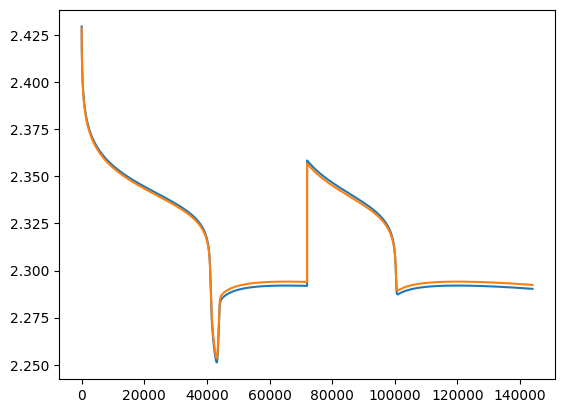

In [44]:
import matplotlib.pyplot as plt
plt.plot(data['EH'])
plt.plot(data['EL'])
plt.show()

In [51]:
data['V'] = data.apply(lambda row: bisection_method(2.5,2.1,row[0],row[1],1.6), axis=1)


# Defined in the code
EH0 = 2.35
EL0 = 2.195
iH0 = 10
iL0 = 5
R = 8.3145
T = 298
F = 96490
fh = 0.7296
fl = 0.06654
ar = 0.96


data['iH'] = data.apply(lambda row: high_BV(iH0,ar,F,R,T,row[2],row[0]), axis=1)
data['iL'] = data.apply(lambda row: low_BV(iH0,ar,F,R,T,row[2],row[1]), axis=1)


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\1465094466.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['V'] = data.apply(lambda row: bisection_method(2.5,2.1,row[0],row[1],1.6), axis=1)
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\1465094466.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['iH'] = data.apply(lambda row: high_BV(iH0,ar,F,R,T,row[2],row[0]), axis=1)
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_24532\1465094466.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [52]:
print(data)

              EH        EL         V        iH        iL
0       2.429525  2.428584  2.428499 -1.536292 -0.127416
1       2.429171  2.428060  2.428088 -1.621357  0.042714
2       2.428826  2.427711  2.427742 -1.623403  0.046806
3       2.428491  2.427375  2.427406 -1.623487  0.046974
4       2.428163  2.427047  2.427079 -1.623529  0.047059
...          ...       ...       ...       ...       ...
144008  2.290259  2.292340  2.290243 -0.024863 -3.150274
144009  2.290259  2.292340  2.290243 -0.024863 -3.150274
144010  2.290259  2.292340  2.290243 -0.024863 -3.150274
144011  2.290259  2.292340  2.290242 -0.024863 -3.150274
144012  2.290259  2.292340  2.290242 -0.024863 -3.150274

[144013 rows x 5 columns]
